In [7]:
import numpy as np
import glob
import xarray as xr 
import matplotlib.pyplot as plt
from collections import namedtuple
import pandas
import glob
import sys, os
sys.path.insert(0, os.path.abspath('./lib'))

from lib import read_xarray

In [8]:
def find_neighbours(mask_ref,listMasks): 
    '''
        permet de chercher les zones voisines 
        taille1 et taille2 permettent de checker si un des deux masks n'est pas déjà inclu dans un autre
    '''
    lst_neighbours = []
    for  mask2compare in listMasks:
        if mask_ref.identical(mask2compare): 
#             print("identical")
            continue 
        else: 
            somme          = np.sum((mask_ref.mask.values == 1) & (mask2compare.mask.values == 1))
            tailleRef      = np.sum(~np.isnan(mask_ref.mask.values ))
            taille2compare = np.sum(~np.isnan(mask2compare.mask.values ))
            if somme > 0 and somme!=tailleRef and somme!=taille2compare: 
                lst_neighbours.append(str(mask2compare.id.values))  
    return(lst_neighbours)

def find_neighbours_old(mask_ref,listMasks): 
    lst_neighbours = []
    for  mask2compare in listMasks:
        if mask_ref.identical(mask2compare): 
            continue 
        else: 
            ind = np.where((mask_ref.mask.values == 1) & (mask2compare.mask.values == 1))
            somme = ind[0].size
            if somme > 0: 
                lst_neighbours.append(str(mask2compare.id.values) )  
    return(lst_neighbours)


def check_existing_mask_v2(mask_temp,ds_mask):
    '''
        check if mask_ref is already in the xarray 
        return flag (= True is mask_ref exists)       
    '''
    list_str = ds_mask.id.values
    for id in list_str:
        mask2compare = ds_mask.mask.sel(id = id)      
        somme = np.sum(mask_temp.values ==  mask2compare.values)
        norme = np.sum((~np.isnan(mask_temp.values)) + (~np.isnan(mask2compare.values)))
        if somme/norme==1:
            flag = True
            break
        else:
            flag = False
    return flag    


# test de rendre ça de maniere recursive 
def create_new_mask(ds_mask, id_ref,listMasks):
    '''
        on ajoute a ds_mask un mask egal a mask_ref + les masks voisins dans la liste des masks voisins 
    '''
    mask_ref = ds_mask.sel(id = id_ref).copy(deep=True)
    for  mask2compare in listMasks:
        new_id = str(mask_ref.mask.id.values) +'+'+ str(mask2compare.mask.id.values) 
        mask_ref = ds_mask.sel(id = id_ref).copy(deep=True)
        ds_temp = mask_ref.copy(deep=True)
        ind = np.where((mask_ref.mask == 1 ) + (mask2compare.mask == 1))
        ds_temp.mask.values[ind] = 1
        flag = check_existing_mask_v2(ds_temp.mask, ds_mask) # check if mask already exists
        if (not flag) and (new_id not in ds_mask.id.values): 
            ds_temp = ds_temp.assign_coords(id =[new_id]) 
            ds_mask  = xr.concat([ds_mask,ds_temp],dim = 'id')
        else: 
            pass
    return ds_mask

def check_existing_mask(mask_temp,ds_mask):
    '''
        check if mask_ref is already in the xarray 
        return flag (= True is mask_ref exists)       
    '''
#     print(listMasks)
    list_str = ds_mask.id.values
    for id in list_str:
        mask2compare = ds_mask.mask.sel(id = id)      
#         ds_diff = mask2compare.values - mask_ref.values 
        if mask_temp.equals(mask2compare):
            flag = True
            break
        else:
            flag = False
    return flag    



In [ ]:
# #deja il faut ploter les differents masks pour voir à quoi ils ressemblent

# dir_mask = '/home/mrpa/borderiesm/stageEMI/Codes/StageEMI/Masques_netcdf/'

# dep =  'FRK24' #'FRJ13'# 'FRK24'
# dep_file  = dir_mask+'Departement/' + dep +'.nc'
# ds_dep    = read_xarray(dep_file)
    
# fig, axes = plt.subplots(nrows= 3 ,ncols=3,figsize=(20,10))
# ax = axes.flat
# ds_dep.mask.isel(id=0).plot(ax =ax[-1])

# # list zones sympo 
# list_subzones = glob.glob(dir_mask +'ZONE_SYMPO/'+ '38*.nc')
# print(len(list_subzones))
# for isub,subzone in enumerate(list_subzones):
#     ds_sympo = read_xarray(subzone)
#     ds_sympo.mask.isel(id=0).plot(ax =ax[isub])
#     ax[isub].set_title(ds_sympo.id.values,fontsize = 15)
# fig.tight_layout()
# # ds_Isere = conversion(ds_Isere_ini) # pour les convertir en WME
# n_subzones = len(list_subzones)

In [10]:
# ecriture d'une fonction qui cres bcp de combinaisons possible de masks

def create_combination_subzones(dir_mask,dep_id,n_subzones,fname_out):
    '''
    calcul et creation d'une multitude de combinaison de zones sympos. 
    in:
        - dir_mask: répertoire de là où sont stocké les fichiers des zones sympos
        - dep_id: numéro du département (38 dans le cas de l'Isère)
        - n_subzones: nombre de zones sympos dans le département 
        - fname_out: fichier où sont stockés tous les différents masks
    '''
    ds_mask = xr.Dataset()
    '''
       1 - Mask global: contient la somme des zones sympos
    '''
    for n in range(1,n_subzones+1):
        file_2 = dir_mask+'{}{:02d}.nc'.format(dep_id,n)   
        ds_2   = read_xarray(file_2)
        ds_2 = ds_2.reset_index("id",drop=True)# pour pouvoir les ajouter 
        ds_mask = xr.merge([ds_mask,ds_2],join='outer')
    ds_mask = ds_mask.assign_coords(id = ['departement'])
    ds_mask.mask.attrs["name"] = 'combinaisons des zones sympos'

    '''
       2 - Mask de chaque zone sur le grand domaine 'departement' 
    '''
    for n in range(1,n_subzones+1):
        file_2 = dir_mask+'{}{:02d}.nc'.format(dep_id,n)   
        ds_2   = read_xarray(file_2)
        new_id = ds_2.id.values[0]
        if new_id in ds_mask.id.values: 
            continue
        ds_3 = ds_2 *ds_mask.sel(id="departement") 
        ds_3 = ds_3.assign_coords(id = [new_id]) #,{attrs:"toto" })
        ds_mask  = xr.concat([ds_mask,ds_3],dim = 'id')
        del(ds_3,ds_2)

    '''
       3 - Mask des somme des zones sympos voisines 
    '''
    lst_id_before = ds_mask.id.values

    for no_ref in range(1,n_subzones+1):
        id_ref   = '{}{:02d}'.format(dep_id,no_ref)   
        mask_ref = ds_mask.sel(id = id_ref).copy(deep=True)
        # on recupère toutes les zones voisines à la zone ref
        listMasks = [ds_mask.sel(id = '{}{:02d}'.format(dep_id,i)) for i in range(1,n_subzones + 1)]
        list_neighbours = find_neighbours(mask_ref,listMasks)
    #     print("{} voisin avec {}".format(mask_ref.id.values,list_neighbours))
    #     on crée les nouveaux mask qui englobent mask_ref + voisin
        listMasks = [ds_mask.sel(id = id) for id in list_neighbours]  
        mask_ref = ds_mask.sel(id = id_ref).copy(deep=True)
        ds_mask = create_new_mask(ds_mask, id_ref,listMasks)

    '''
       4 - somme entre chaque groupement de zones sympos 
    '''
    lst_int = ds_mask.id.values
    lst_new_id = [key for key in lst_int if key not in lst_id_before]


    for id_ref in lst_new_id: 
        mask_ref = ds_mask.sel(id = id_ref).copy(deep=True) 
        listMasks = [ds_mask.sel(id = id) for id in ds_mask.id.values]
        list_neighbours = find_neighbours(mask_ref,listMasks)
#         print("{} voisin avec {}".format(id_ref,list_neighbours))

        if len(list_neighbours) == 0: 
            continue
        listMasks = [ds_mask.sel(id = id) for id in list_neighbours]  
        mask_ref = ds_mask.sel(id = id_ref).copy(deep=True)
        ds_mask = create_new_mask(ds_mask, id_ref,listMasks)

    ds_mask.to_netcdf(fname_out)
    return ds_mask



In [17]:
dep_id = '38'
dir_mask = '/home/mrpa/borderiesm/stageEMI/Codes/StageEMI/Masques_netcdf/ZONE_SYMPO/'
list_subzones = glob.glob(dir_mask + '38*.nc')
n_subzones = len(list_subzones)  # nombre de zones sympos initiales
fname_out = dir_mask + '_mask_zones_sympos_multiple.nc'
if not os.path.exists(fname_out): 
    ds_mask = create_combination_subzones(dir_mask,dep_id,n_subzones,fname_out) 
else: 
    ds_mask = read_xarray(fname_out)

    

['departement' '3801' '3802' '3803' '3804' '3805' '3806' '3807' '3808'
 '3801+3802' '3801+3803' '3802+3803' '3802+3804' '3803+3804' '3803+3806'
 '3804+3805' '3804+3806' '3804+3807' '3804+3808' '3805+3807' '3805+3808'
 '3806+3808' '3807+3808' '3801+3802+3803' '3801+3802+3804'
 '3801+3802+3803+3804' '3801+3802+3803+3806' '3801+3802+3804+3805'
 '3801+3802+3804+3806' '3801+3802+3804+3807' '3801+3802+3804+3808'
 '3801+3803+3804' '3801+3803+3806' '3801+3803+3804+3805'
 '3801+3803+3804+3806' '3801+3803+3804+3807' '3801+3803+3804+3808'
 '3801+3803+3806+3808' '3801+3803+3801+3802+3804+3805'
 '3801+3803+3801+3802+3804+3806' '3801+3803+3801+3802+3804+3807'
 '3801+3803+3801+3802+3804+3808' '3802+3803+3804' '3802+3803+3806'
 '3802+3803+3804+3805' '3802+3803+3804+3806' '3802+3803+3804+3807'
 '3802+3803+3804+3808' '3802+3803+3806+3808'
 '3802+3803+3801+3803+3806+3808' '3802+3804+3805' '3802+3804+3806'
 '3802+3804+3807' '3802+3804+3808' '3802+3804+3805+3807'
 '3802+3804+3805+3808' '3802+3804+3806+3808

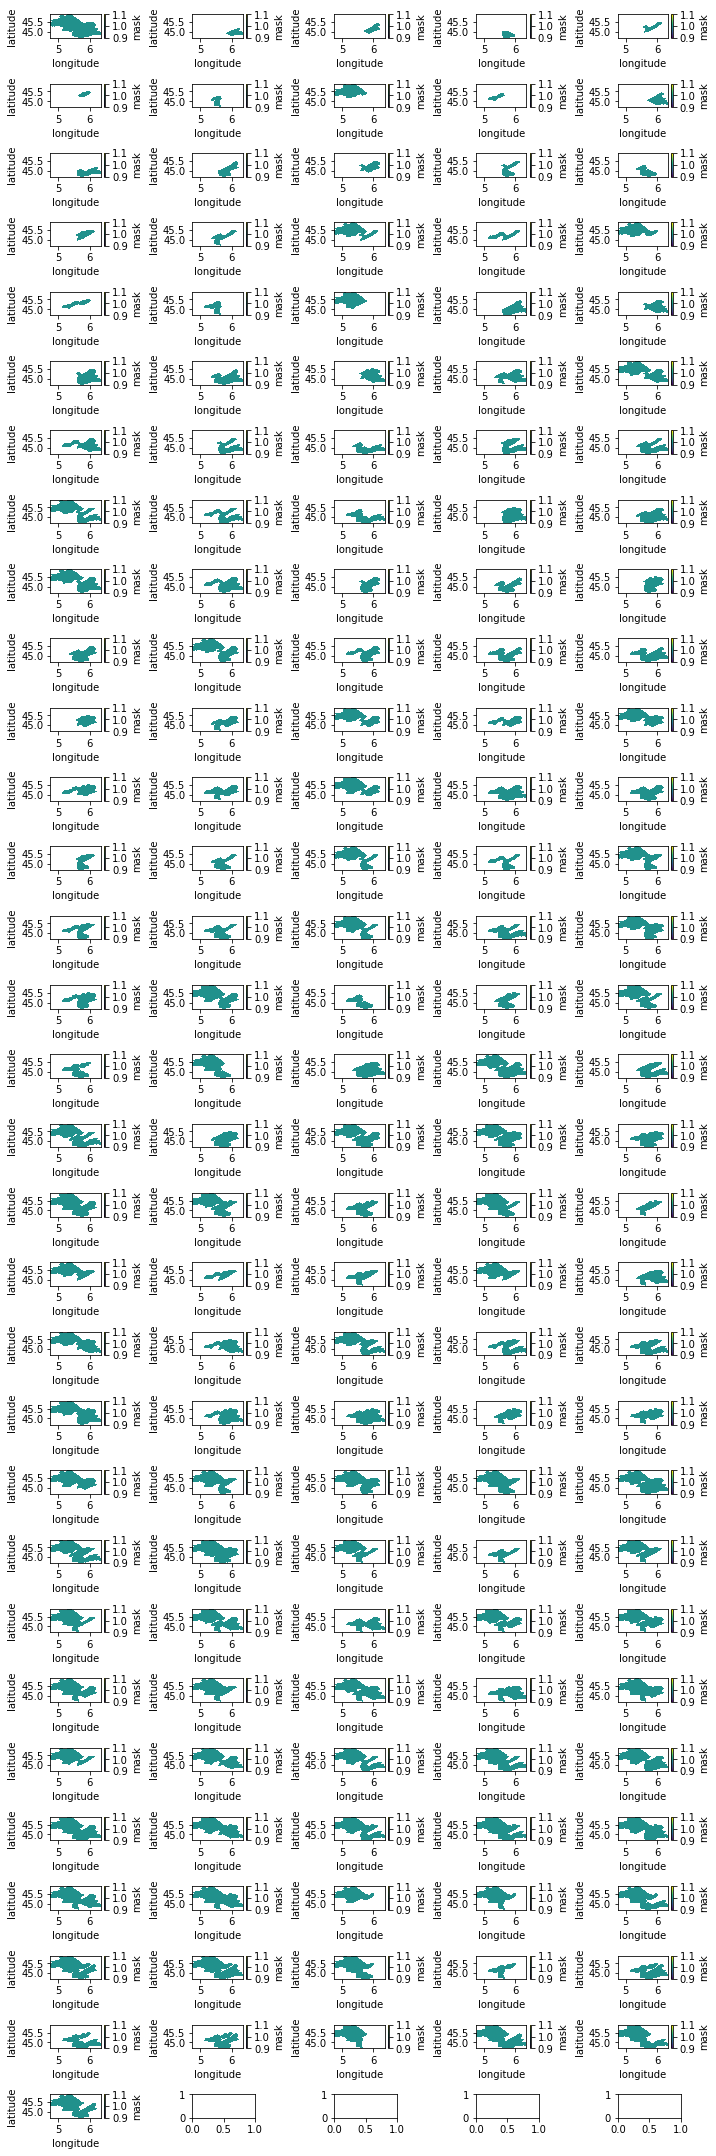

In [20]:
print(ds_mask.id.values,ds_mask.id.values.size)
ds_out = ds_mask.copy()
fig,axes = plt.subplots(nrows = 31,ncols=5,figsize = (10,30))
ax = axes.flat
for i,id in enumerate(ds_out.id.values):
    ds_out.sel(id=id).mask.plot(ax=ax[i])
    ax[i].set_title('')
fig.tight_layout()